# Predictive performance for three families of basis functions designed to predict the global surface air temperature

# 1. Polynomial basis 

In [1]:
#import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse 

In [2]:
#Load the data
df=pd.read_csv('surf_temp.csv')

In [3]:
#Step 1: Define the polynomial basis functions 
def design_mat_pol(x, p):
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, p + 1):
        phi_i = (x ** i).reshape(-1, 1)
        phi_mat = np.hstack((phi_mat, phi_i))
    return phi_mat

In [4]:
#Step 2:Define regression model for prediction 
def np_predict(xmat, y):
    bhat = np.linalg.inv(xmat.T @ xmat) @ xmat.T @ y
    yhat = xmat @ bhat
    return yhat

def skl_predict_new(phi_mat, y, phi_mat_new):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(phi_mat, y)
    y_hat = lr.predict(phi_mat_new)
    return y_hat

In [5]:
#Step 3:Load out x(feature) and y(target variable)
x = df['year'].values
y = df['temp'].values

#Re-scale x
x = (df['year'].values - 1940) / 84

In [6]:
#Step 4:Split data into training, validation, and test sets
y = df['temp'].to_numpy(dtype=float)
x = df[['year', 'month']].to_numpy(dtype=float)

# Re-scale 'year' column 
x[:, 0] = (x[:, 0] - 1940) / 84

x_tv, x_test, y_tv, y_test = train_test_split(x, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)

In [7]:
#Step 5:Create dummy variables for training and validation sets
umat_train = pd.get_dummies(x_train[:, 1], drop_first=True, dtype=int).values
umat_vali = pd.get_dummies(x_vali[:, 1], drop_first=True, dtype=int).values
umat_test = pd.get_dummies(x_test[:, 1], drop_first=True, dtype=int).values

In [8]:
#Step 6:Setting up p for polynomial degrees from 1 to 10 
p = np.arange(1, 11)

In [9]:
# Step 7:Calculate MSE
n_p = len(p)
mse_train = np.empty(n_p)
mse_vali = np.empty(n_p)

for i in range(n_p):
    # Generate polynomial design matrices for training and validation sets
    phimat_train = design_mat_pol(x_train[:, 0], p[i])  # Polynomial features for training
    phimat_vali = design_mat_pol(x_vali[:, 0], p[i])    # Polynomial features for validation

    # Create the full design matrices by adding the dummy variables
    xmat_train = np.hstack((phimat_train, umat_train))  # Train matrix
    xmat_vali = np.hstack((phimat_vali, umat_vali))     # Validation matrix

    # Fit the model and predict on training and validation data
    yhat_train = skl_predict_new(xmat_train, y_train, xmat_train)
    yhat_vali = skl_predict_new(xmat_train, y_train, xmat_vali)

    # Calculate MSE for training and validation for the number of breakpoints
    mse_train[i] = mse(y_train, yhat_train)
    mse_vali[i] = mse(y_vali, yhat_vali)

<function matplotlib.pyplot.show(close=None, block=None)>

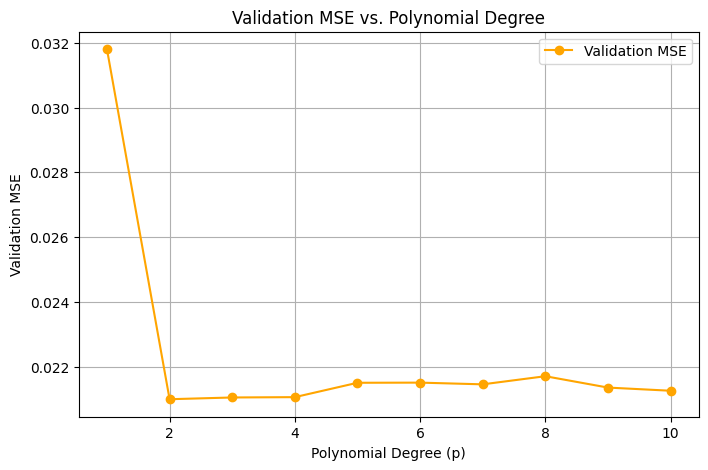

In [10]:
# Step 8:Plot the validation MSE
plt.figure(figsize=(8, 5))
plt.plot(p, mse_vali, marker='o', linestyle='-', color='orange', label='Validation MSE')
plt.xlabel('Polynomial Degree (p)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Polynomial Degree')
plt.grid(True)
plt.legend()
plt.show

In [11]:
# Step 9: Identify the best polynomial degree (minimizing validation MSE)
min_mse_index = np.argmin(mse_vali)  # Get the index of the minimum MSE
optimal_degree = p[min_mse_index]    # Get the corresponding polynomial degree
print(f'Optimal Polynomial Degree: {optimal_degree}')

Optimal Polynomial Degree: 2


In [12]:
#Optimal Polynomial Degree found to be 2
optimal_p=2

In [13]:
#Step 10: Use the optimal polynominal degree to regenerate training and test sets 
phimat_train = design_mat_pol(x_train[:, 0], optimal_p)  # Polynomial features for training
phimat_test = design_mat_pol(x_test[:, 0], optimal_p)    # Polynomial features for test

# Combine polynomial features with dummy variables
xmat_train = np.hstack((phimat_train, umat_train))  # Full training design matrix
xmat_test = np.hstack((phimat_test, umat_test))     # Full test design matrix

# Fit the model on the training data and predict on the test data
yhat_test = skl_predict_new(xmat_train, y_train, xmat_test)

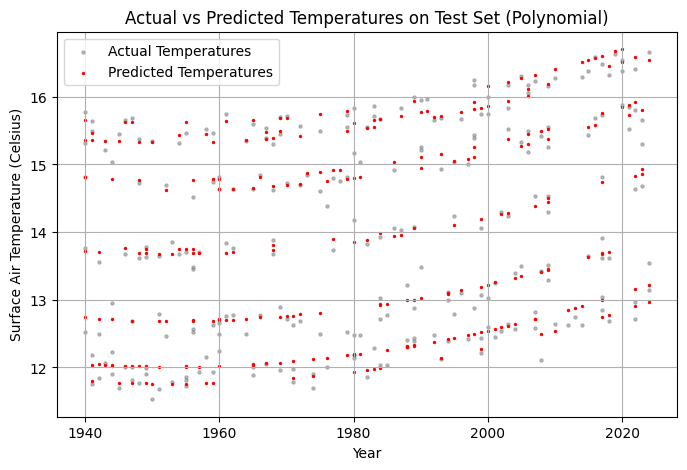

Test MSE with optimal degree of 2: 0.02380


In [14]:
#Step 11: Plot the predicted vs actual temperatures for the test set
#rescale back to year
years_test = (x_test[:, 0] * 84) + 1940.
plt.figure(figsize=(8, 5))
plt.scatter(years_test, y_test, color='grey', s=5, alpha=0.5, label='Actual Temperatures')  
plt.scatter(years_test, yhat_test, color='red', s=2, label='Predicted Temperatures')  
plt.xlabel('Year')
plt.ylabel('Surface Air Temperature (Celsius)')
plt.title('Actual vs Predicted Temperatures on Test Set (Polynomial)')
plt.grid(True)
plt.legend()
plt.show()

test_mse = mse(y_test, yhat_test)
print(f'Test MSE with optimal degree of 2: {test_mse:.5f}')

# 2. Piece-wise Constant Model

In [15]:
#import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse 

In [16]:
#Load the data
df=pd.read_csv('surf_temp.csv')

In [17]:
#Step 1:Define the set of piece-wise constant basis function 
def design_mat_pwc(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.ones((n, 1))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [18]:
#Step 2:Define regression model for prediction 
def skl_predict(xmat, y):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(xmat, y)
    yhat = lr.predict(xmat)
    print('Rank:{}/{}'.format(lr.rank_, xmat.shape[1]))
    return yhat

def skl_predict_new(phi_mat, y, phi_mat_new):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(phi_mat, y)
    y_hat = lr.predict(phi_mat_new)
    return y_hat

In [19]:
#Step 3:Load out x(feature) and y(target variable)
x = df['year'].values
y = df['temp'].values

#Re-scale x
x = (df['year'].values - 1940) / 84

In [20]:
#Step 4:Split data into training, validation, and test sets
y = df['temp'].to_numpy(dtype=float)
x = df[['year', 'month']].to_numpy(dtype=float)

# Re-scale 'year' column 
x[:, 0] = (x[:, 0] - 1940) / 84

x_tv, x_test, y_tv, y_test = train_test_split(x, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)

In [21]:
#Step 5: Create dummy variables for training and validation sets
umat_train = pd.get_dummies(x_train[:, 1], drop_first=True, dtype=int).values
umat_vali = pd.get_dummies(x_vali[:, 1], drop_first=True, dtype=int).values
umat_test = pd.get_dummies(x_test[:, 1], drop_first=True, dtype=int).values

In [22]:
#Step 6: Setting up k for number of breakpoints from 1 to 30
k = np.arange(1, 31)

In [23]:
# Step 7: Calculate MSE
n_k = len(k)
mse_train = np.empty(n_k)
mse_vali = np.empty(n_k)

for i in range(n_k):
    # Generate piece-wise constant design matrix for training and validation sets
    phimat_train = design_mat_pwc(x_train[:, 0], k[i])  # Piece-wise constant features for training
    phimat_vali = design_mat_pwc(x_vali[:, 0], k[i])    # Piece-wise constant features for validation

    # Create the full design matrices by adding the dummy variables
    xmat_train = np.hstack((phimat_train, umat_train))  # Train matrix
    xmat_vali = np.hstack((phimat_vali, umat_vali))     # Validation matrix

    # Fit the model and predict on training and validation data
    yhat_train = skl_predict_new(xmat_train, y_train, xmat_train)
    yhat_vali = skl_predict_new(xmat_train, y_train, xmat_vali)

    # Calculate MSE for training and validation for the number of breakpoints
    mse_train[i] = mse(y_train, yhat_train)
    mse_vali[i] = mse(y_vali, yhat_vali)

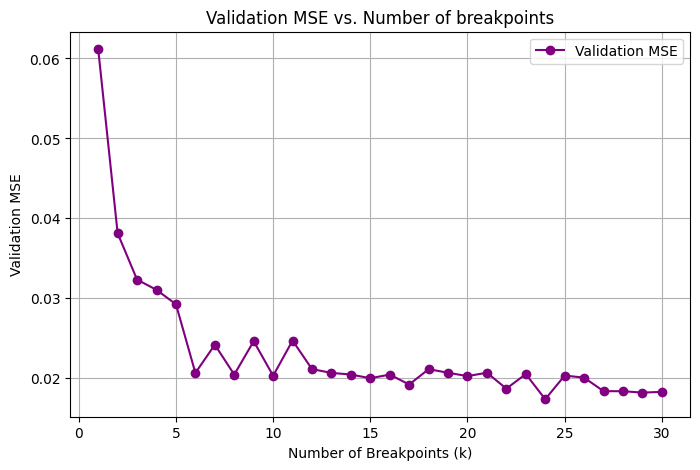

In [24]:
# Step 8: Plot the validation MSE
plt.figure(figsize=(8, 5))
plt.plot(k, mse_vali, marker='o', linestyle='-', color='purple', label='Validation MSE')
plt.xlabel('Number of Breakpoints (k)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Number of breakpoints')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Step 9: Identify the best number of break points (minimizing validation MSE)
min_mse_index = np.argmin(mse_vali)  
optimal_k = k[min_mse_index]    
print(f'The optimal number of breakpoints is: {optimal_k}')

The optimal number of breakpoints is: 24


In [26]:
#Optimal  number of breakpoints found to be 24
optimal_k_pwc=24

In [27]:
#Step 10: Use the optimal number of breakpoints to regenerate training and test sets 
phimat_train = design_mat_pwc(x_train[:, 0], optimal_k_pwc)  # Piece-wise constant features for training
phimat_test = design_mat_pwc(x_test[:, 0], optimal_k_pwc)    # Piece-wise constant features for test

# Combine polynomial features with dummy variables
xmat_train = np.hstack((phimat_train, umat_train))  # Full training design matrix
xmat_test = np.hstack((phimat_test, umat_test))     # Full test design matrix

# Fit the model on the training data and predict on the test data
yhat_test = skl_predict_new(xmat_train, y_train, xmat_test)

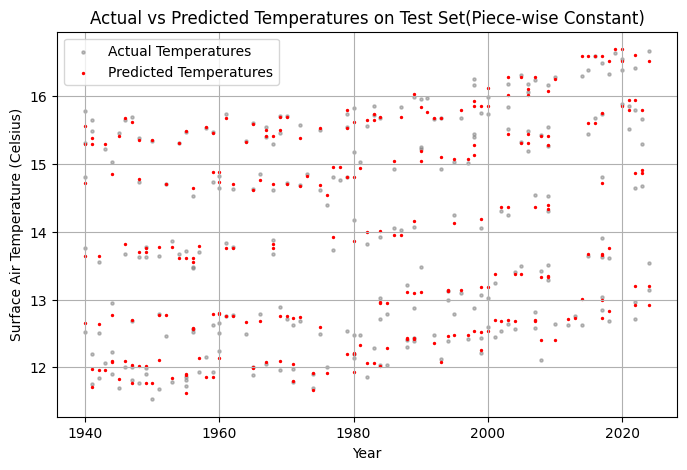

Test MSE with optimal number of breakpoints of 24: 0.02142


In [28]:
#Step 11: Plot the predicted vs actual temperatures for the test set
#rescale back to year
years_test = (x_test[:, 0] * 84) + 1940.
plt.figure(figsize=(8, 5))
plt.scatter(years_test, y_test, color='grey', s=5, alpha=0.5, label='Actual Temperatures')  
plt.scatter(years_test, yhat_test, color='red', s=2, label='Predicted Temperatures')  
plt.xlabel('Year')
plt.ylabel('Surface Air Temperature (Celsius)')
plt.title('Actual vs Predicted Temperatures on Test Set(Piece-wise Constant)')
plt.grid(True)
plt.legend()
plt.show()

test_mse = mse(y_test, yhat_test)
print(f'Test MSE with optimal number of breakpoints of 24: {test_mse:.5f}')

# 3. Piece-wise Linear Model

In [29]:
#import libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as mse 

In [30]:
#Load the data
df=pd.read_csv('surf_temp.csv')

In [31]:
#Step 1:Define the piece-wise linear model 
def design_mat_pwl(x, k):
    x_min = np.min(x)
    x_max = np.max(x)
    n = len(x)
    phi_mat = np.hstack((np.ones((n, 1)), x.reshape(-1, 1)))
    for i in range(1, k + 1):
        t = x_min + i * (x_max - x_min) / (k + 1)
        phi_i = (x - t) * (x > t)
        phi_mat = np.hstack((phi_mat, phi_i.reshape(-1, 1)))
    return phi_mat

In [32]:
#Step 2:Define regression model for prediction 
def skl_predict(xmat, y):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(xmat, y)
    yhat = lr.predict(xmat)
    print('Rank:{}/{}'.format(lr.rank_, xmat.shape[1]))
    return yhat

def skl_predict_new(phi_mat, y, phi_mat_new):
    lr = LinearRegression(fit_intercept=False)
    lr.fit(phi_mat, y)
    y_hat = lr.predict(phi_mat_new)
    return y_hat

In [33]:
#Step 3:Load out x(feature) and y(target variable)
x = df['year'].values
y = df['temp'].values

#Re-scale x
x = (df['year'].values - 1940) / 84

In [34]:
#Step 4:Split data into training, validation, and test sets
y = df['temp'].to_numpy(dtype=float)
x = df[['year', 'month']].to_numpy(dtype=float)

# Re-scale 'year' column 
x[:, 0] = (x[:, 0] - 1940) / 84

x_tv, x_test, y_tv, y_test = train_test_split(x, y, test_size=1/4, random_state=1)
x_train, x_vali, y_train, y_vali = train_test_split(x_tv, y_tv, test_size=1/3, random_state=1)

In [35]:
#Step 5: Create dummy variables for training and validation sets
umat_train = pd.get_dummies(x_train[:, 1], drop_first=True, dtype=int).values
umat_vali = pd.get_dummies(x_vali[:, 1], drop_first=True, dtype=int).values
umat_test = pd.get_dummies(x_test[:, 1], drop_first=True, dtype=int).values

In [36]:
#Step 6: Setting up k for number of breakpoints from 1 to 30
k = np.arange(1, 31)

In [37]:
# Step 7: Calculate MSE
n_k = len(k)
mse_train = np.empty(n_k)
mse_vali = np.empty(n_k)

for i in range(n_k):
    # Generate piece-wise linear design matrix for training and validation sets
    phimat_train = design_mat_pwl(x_train[:, 0], k[i])  # Piece-wise linear features  for training
    phimat_vali = design_mat_pwl(x_vali[:, 0], k[i])    # Piece-wise linear features for validation

    # Create the full design matrices by adding the dummy variables
    xmat_train = np.hstack((phimat_train, umat_train))  # Train matrix
    xmat_vali = np.hstack((phimat_vali, umat_vali))     # Validation matrix

    # Fit the model and predict on training and validation data
    yhat_train = skl_predict_new(xmat_train, y_train, xmat_train)
    yhat_vali = skl_predict_new(xmat_train, y_train, xmat_vali)

    # Calculate MSE for training and validation for the number of breakpoints
    mse_train[i] = mse(y_train, yhat_train)
    mse_vali[i] = mse(y_vali, yhat_vali)

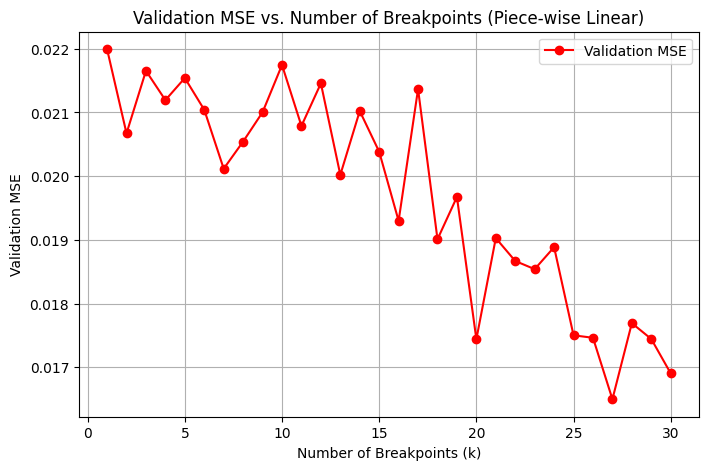

In [38]:
# Step 8: Plot the validation MSE
plt.figure(figsize=(8, 5))
plt.plot(k, mse_vali, marker='o', linestyle='-', color='red', label='Validation MSE')
plt.xlabel('Number of Breakpoints (k)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Number of Breakpoints (Piece-wise Linear)')
plt.grid(True)
plt.legend()
plt.show()

In [39]:
# Step 9: Identify the best number of break points (minimizing validation MSE)
min_mse_index = np.argmin(mse_vali)  
optimal_k = k[min_mse_index]    
print(f'The optimal number of breakpoints is: {optimal_k}')

The optimal number of breakpoints is: 27


In [40]:
#Optimal  number of breakpoints found to be 27
optimal_k_pwl=27

In [41]:
#Step 10: Use the optimal number of breakpoints to regenerate training and test sets 
phimat_train = design_mat_pwl(x_train[:, 0], optimal_k_pwl)  # Piece-wise linear features for training
phimat_test = design_mat_pwl(x_test[:, 0], optimal_k_pwl)    # Piece-wise linear features for test

# Combine polynomial features with dummy variables
xmat_train = np.hstack((phimat_train, umat_train))  # Full training design matrix
xmat_test = np.hstack((phimat_test, umat_test))     # Full test design matrix

# Fit the model on the training data and predict on the test data
yhat_test = skl_predict_new(xmat_train, y_train, xmat_test)

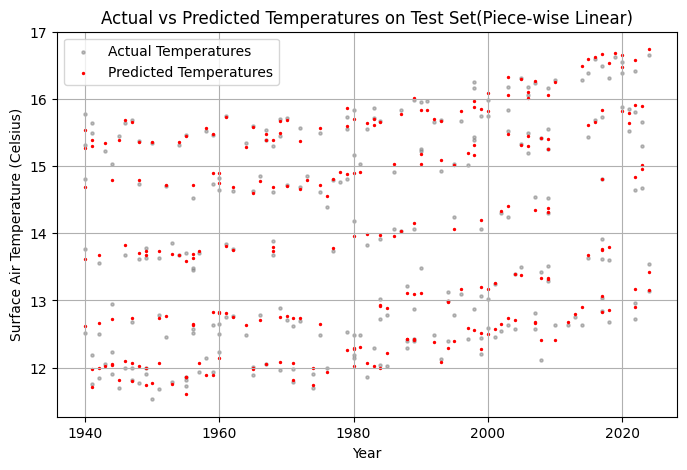

Test MSE with optimal number of breakpoints of 27: 0.01928


In [42]:
#Step 11: Plot the predicted vs actual temperatures for the test set
#rescale back to year
years_test = (x_test[:, 0] * 84) + 1940.
plt.figure(figsize=(8, 5))
plt.scatter(years_test, y_test, color='grey', s=5, alpha=0.5, label='Actual Temperatures')  
plt.scatter(years_test, yhat_test, color='red', s=2, label='Predicted Temperatures')  
plt.xlabel('Year')
plt.ylabel('Surface Air Temperature (Celsius)')
plt.title('Actual vs Predicted Temperatures on Test Set(Piece-wise Linear)')
plt.grid(True)
plt.legend()
plt.show()

test_mse = mse(y_test, yhat_test)
print(f'Test MSE with optimal number of breakpoints of 27: {test_mse:.5f}')

# 4. To find the best model

In [43]:
#Step 1: Use the optimal hyperparameters for each family of basis functions 

#Polynomial basis function 
phimat_train_pol= design_mat_pol(x_train[:, 0], optimal_p)  
phimat_test_pol = design_mat_pol(x_test[:, 0], optimal_p)    

# Combine polynomial features with dummy variables
xmat_train_pol = np.hstack((phimat_train_pol, umat_train))  
xmat_test_pol = np.hstack((phimat_test_pol, umat_test))     

#Piece-wise constant basis function 
phimat_train_pwc = design_mat_pwc(x_train[:, 0], optimal_k_pwc)  
phimat_test_pwc = design_mat_pwc(x_test[:, 0], optimal_k_pwc)    

# Combine polynomial features with dummy variables
xmat_train_pwc = np.hstack((phimat_train_pwc, umat_train))  
xmat_test_pwc = np.hstack((phimat_test_pwc, umat_test))     

#Piece-wise linear basis function 
phimat_train_pwl = design_mat_pwl(x_train[:, 0], optimal_k_pwl)  
phimat_test_pwl = design_mat_pwl(x_test[:, 0], optimal_k_pwl) 

xmat_train_pwl = np.hstack((phimat_train_pwl, umat_train))  
xmat_test_pwl = np.hstack((phimat_test_pwl, umat_test))     

In [44]:
# Step 2: Fit the models for each family of basis functions 

#Polynimial basis function 
yhat_test_pol = skl_predict_new(xmat_train_pol, y_train, xmat_test_pol)
test_mse_pol = mse(y_test, yhat_test_pol)
print(f'Test MSE for Polynomial Basis Function: {test_mse_pol:.5f}')

#Piece-wise constant basis function 
yhat_test_pwc = skl_predict_new(xmat_train_pwc, y_train, xmat_test_pwc)
test_mse_pwc = mse(y_test, yhat_test_pwc)
print(f'Test MSE for Piece-wise Constant Basis Function: {test_mse_pwc:.5f}')

#Piece-wise linear basis function 
yhat_test_pwl = skl_predict_new(xmat_train_pwl, y_train, xmat_test_pwl)
test_mse_pwl = mse(y_test, yhat_test_pwl)
print(f'Test MSE for Piece-wise Linear Basis Function: {test_mse_pwl:.5f}')

Test MSE for Polynomial Basis Function: 0.02380
Test MSE for Piece-wise Constant Basis Function: 0.02142
Test MSE for Piece-wise Linear Basis Function: 0.01928


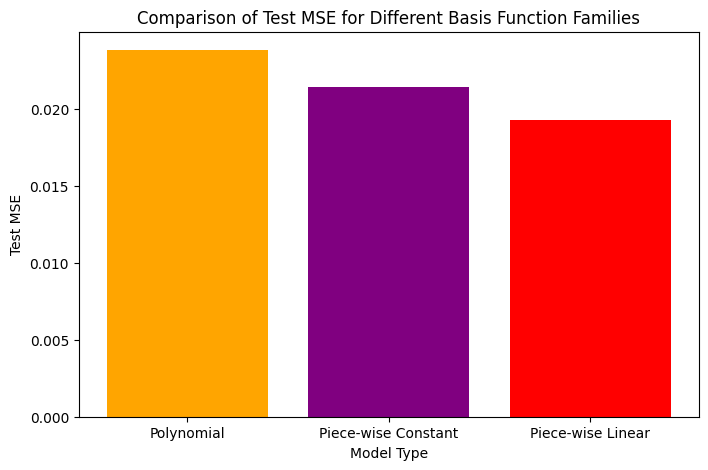

The best-performing model is: Piece-wise Linear with a test MSE of 0.01928


In [45]:
# Step 3: Compare the MSE values and visualize the results

# Plot the MSE values for comparison
plt.figure(figsize=(8, 5))
models = ['Polynomial', 'Piece-wise Constant', 'Piece-wise Linear']
mse_values = [test_mse_pol, test_mse_pwc, test_mse_pwl]

plt.bar(models, mse_values, color=['orange', 'purple', 'red'])
plt.xlabel('Model Type')
plt.ylabel('Test MSE')
plt.title('Comparison of Test MSE for Different Basis Function Families')
plt.show()

# Print out the best performing model based on the lowest test MSE
best_model = models[np.argmin(mse_values)]
print(f"The best-performing model is: {best_model} with a test MSE of {min(mse_values):.5f}")

# 5. Forecasting the future weather

In [46]:
# Step 1: Prepare the input data for October, November, and December 2024
# Year for 2024 (assuming you scaled by subtracting 1940 and dividing by 84)
year_forecast = np.array([(2024 - 1940) / 84])  # Scaled year

# Repeat the year for each month (October, November, December)
year_forecast_repeated = np.repeat(year_forecast, 3)  # Same year for all three months

# Months for October (10), November (11), and December (12)
months_forecast = np.array([10, 11, 12])

# Step 2: Generate dummy variables for the forecast months (same method as training)
# Use the column names from the dummies of the training set for consistency
umat_forecast = pd.get_dummies(months_forecast, drop_first=True).reindex(
    columns=pd.get_dummies(x_train[:, 1], drop_first=True).columns, fill_value=0).values

# Step 3: Generate the piece-wise linear design matrix for the forecast year using the optimal number of breakpoints
phimat_forecast = design_mat_pwl(year_forecast_repeated, optimal_k_pwl)  # Use the optimal breakpoints

# Step 4: Combine the piece-wise linear basis functions with the month dummy variables into the forecast design matrix
xmat_forecast = np.hstack((phimat_forecast, umat_forecast))

# Step 5: Make predictions using the trained model (piece-wise linear)
yhat_forecast = skl_predict_new(xmat_train, y_train, xmat_forecast)

# Step 6: Print the forecasted temperatures for October, November, and December 2024
forecast_months = ['October', 'November', 'December']
for month, temp in zip(forecast_months, yhat_forecast):
    print(f"Forecasted temperature for {month} 2024: {temp:.2f} °C")


Forecasted temperature for October 2024: 13.92 °C
Forecasted temperature for November 2024: 14.85 °C
Forecasted temperature for December 2024: 14.17 °C
